In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import randint, uniform

pd.options.display.float_format = '{:.2f}'.format

In [2]:
import tensorflow as tf

## IMPORT & EXPLORE

#### FUNCTIONS

##### GRAYSCALE

In [3]:
def generate_augmented_images(images, labels, augmentations_per_image=3, zoom_range=(0.9, 1.3)):
    augmented_images = []
    augmented_labels = []

    # Precompute random values for efficiency
    num_total_augs = len(images) * augmentations_per_image
    random_flips_lr = tf.random.uniform([num_total_augs], 0, 2, dtype=tf.int32)
    random_flips_ud = tf.random.uniform([num_total_augs], 0, 2, dtype=tf.int32)
    random_rotations = tf.random.uniform([num_total_augs], 0, 4, dtype=tf.int32)
    random_brightness = tf.random.uniform([num_total_augs], -0.1, 0.1)
    random_contrasts = tf.random.uniform([num_total_augs], 0.8, 1.2)
    zoom_factors = tf.random.uniform([num_total_augs], zoom_range[0], zoom_range[1])

    # Process images
    aug_idx = 0
    for img, lbl in zip(images, labels):
        # Ensure image is properly shaped for grayscale (h, w, 1)
        if len(img.shape) == 2:
            img = tf.expand_dims(img, axis=-1)

        # Safety check: ensure values are within range [0, 1]
        img = tf.clip_by_value(img, 0.0, 1.0)

        h, w, c = img.shape

        for _ in range(augmentations_per_image):
            # Start with a clean copy of the image
            aug_img = tf.identity(img)

            # Apply random horizontal flip
            if random_flips_lr[aug_idx] > 0:
                aug_img = tf.image.flip_left_right(aug_img)

            # Apply random vertical flip
            if random_flips_ud[aug_idx] > 0:
                aug_img = tf.image.flip_up_down(aug_img)

            # Apply random rotation (90-degree increments)
            aug_img = tf.image.rot90(aug_img, k=random_rotations[aug_idx])

            # Apply random brightness with safety check
            aug_img = tf.image.adjust_brightness(aug_img, random_brightness[aug_idx])
            aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)

            # Apply random contrast with safety check
            aug_img = tf.image.adjust_contrast(aug_img, random_contrasts[aug_idx])
            aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)

            # Gaussian noise - optimized for grayscale
            if tf.random.uniform(()) > 0.7:  # Apply with 30% probability
                noise = tf.random.normal(shape=tf.shape(aug_img), mean=0.0, stddev=0.05)
                aug_img = tf.clip_by_value(aug_img + noise, 0.0, 1.0)

            # Random zoom with more robust logic
            zoom_factor = zoom_factors[aug_idx]

            try:
                if zoom_factor > 1.0:  # Zoom in
                    # Ensure new dimensions are at least 1
                    new_h = tf.maximum(tf.cast(h / zoom_factor, tf.int32), 1)
                    new_w = tf.maximum(tf.cast(w / zoom_factor, tf.int32), 1)

                    # Calculate crop position
                    top = (h - new_h) // 2
                    left = (w - new_w) // 2

                    # Ensure valid crop boundaries
                    if new_h > 0 and new_w > 0 and top >= 0 and left >= 0:
                        aug_img = tf.image.crop_to_bounding_box(aug_img, top, left, new_h, new_w)
                        aug_img = tf.image.resize(aug_img, (h, w))
                else:  # Zoom out
                    # Ensure new dimensions don't exceed int32 max
                    new_h = tf.minimum(tf.cast(h * zoom_factor, tf.int32), tf.int32.max)
                    new_w = tf.minimum(tf.cast(w * zoom_factor, tf.int32), tf.int32.max)

                    # Ensure dimensions are at least 1
                    new_h = tf.maximum(new_h, 1)
                    new_w = tf.maximum(new_w, 1)

                    aug_img = tf.image.resize(aug_img, (new_h, new_w))
                    aug_img = tf.image.resize_with_crop_or_pad(aug_img, h, w)
            except tf.errors.InvalidArgumentError:
                # If zoom causes error, skip this transformation
                pass

            # Random gamma adjustment with safety check
            if tf.random.uniform(()) > 0.7:
                gamma = tf.random.uniform([], 0.8, 1.2)
                aug_img = tf.image.adjust_gamma(aug_img, gamma)
                aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)

            # Random cutout (masking) - safer version
            if tf.random.uniform(()) > 0.8:  # Apply with 20% probability
                mask_size_h = tf.maximum(tf.cast(h * tf.random.uniform([], 0.1, 0.2), tf.int32), 1)
                mask_size_w = tf.maximum(tf.cast(w * tf.random.uniform([], 0.1, 0.2), tf.int32), 1)

                # Ensure mask position is valid
                mask_y = tf.minimum(tf.random.uniform([], 0, h - mask_size_h, dtype=tf.int32), h - 1)
                mask_x = tf.minimum(tf.random.uniform([], 0, w - mask_size_w, dtype=tf.int32), w - 1)

                # Create mask
                mask = tf.zeros([mask_size_h, mask_size_w, 1]) + 0.5  # Gray mask
                paddings = [[mask_y, h - mask_y - mask_size_h],
                           [mask_x, w - mask_x - mask_size_w],
                           [0, 0]]

                # Ensure paddings are valid
                paddings = tf.maximum(paddings, 0)

                mask = tf.pad(mask, paddings)
                mask = tf.cast(mask > 0, aug_img.dtype)
                aug_img = aug_img * (1 - mask) + mask * 0.5

            # Final safety check
            aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)

            # Check for NaN values and replace with safe values
            aug_img = tf.where(tf.math.is_nan(aug_img), tf.zeros_like(aug_img), aug_img)

            # Append the augmented image
            augmented_images.append(aug_img.numpy())
            augmented_labels.append(lbl)
            aug_idx += 1

    return np.array(augmented_images), np.array(augmented_labels)

In [4]:
def display_examples(images, labels, num_examples=5):
    plt.figure(figsize=(10, 10))

    for i in range(num_examples):
        ax = plt.subplot(1, num_examples, i + 1)
        ax.imshow(images[i])  # Display the image
        ax.set_title(f"Label: {labels[i]}")  # Display the label
        ax.axis("off")  # Hide axes

    plt.show()

##### RGB

In [5]:
def generate_augmented_images_rgb(images, labels, augmentations_per_image=3, zoom_range=(0.9, 1.3)):
    augmented_images = []
    augmented_labels = []

    # Precompute random values for efficiency
    num_total_augs = len(images) * augmentations_per_image
    random_flips_lr = tf.random.uniform([num_total_augs], 0, 2, dtype=tf.int32)
    random_flips_ud = tf.random.uniform([num_total_augs], 0, 2, dtype=tf.int32)
    random_rotations = tf.random.uniform([num_total_augs], 0, 4, dtype=tf.int32)
    random_brightness = tf.random.uniform([num_total_augs], -0.1, 0.1)
    random_contrasts = tf.random.uniform([num_total_augs], 0.8, 1.2)
    zoom_factors = tf.random.uniform([num_total_augs], zoom_range[0], zoom_range[1])

    # Process images
    aug_idx = 0
    for img, lbl in zip(images, labels):
        # Ensure image is properly shaped for RGB (h, w, 3)
        if len(img.shape) == 2:
            img = tf.image.grayscale_to_rgb(tf.expand_dims(img, axis=-1))
        elif img.shape[-1] == 1:
            img = tf.image.grayscale_to_rgb(img)

        # Safety check: ensure values are within range [0, 1]
        img = tf.clip_by_value(img, 0.0, 1.0)

        h, w, c = img.shape

        for _ in range(augmentations_per_image):
            aug_img = tf.identity(img)

            # Apply random horizontal flip
            if random_flips_lr[aug_idx] > 0:
                aug_img = tf.image.flip_left_right(aug_img)

            # Apply random vertical flip
            if random_flips_ud[aug_idx] > 0:
                aug_img = tf.image.flip_up_down(aug_img)

            # Apply random rotation (90-degree increments)
            aug_img = tf.image.rot90(aug_img, k=random_rotations[aug_idx])

            # Apply random brightness and contrast adjustments
            aug_img = tf.image.adjust_brightness(aug_img, random_brightness[aug_idx])
            aug_img = tf.image.adjust_contrast(aug_img, random_contrasts[aug_idx])
            aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)

            # Apply Gaussian noise (optimized for RGB)
            if tf.random.uniform(()) > 0.7:  # 30% probability
                noise = tf.random.normal(shape=tf.shape(aug_img), mean=0.0, stddev=0.05)
                aug_img = tf.clip_by_value(aug_img + noise, 0.0, 1.0)

            # Random zoom
            zoom_factor = zoom_factors[aug_idx]
            try:
                if zoom_factor > 1.0:  # Zoom in
                    new_h = tf.maximum(tf.cast(h / zoom_factor, tf.int32), 1)
                    new_w = tf.maximum(tf.cast(w / zoom_factor, tf.int32), 1)
                    top = (h - new_h) // 2
                    left = (w - new_w) // 2

                    if new_h > 0 and new_w > 0 and top >= 0 and left >= 0:
                        aug_img = tf.image.crop_to_bounding_box(aug_img, top, left, new_h, new_w)
                        aug_img = tf.image.resize(aug_img, (h, w))
                else:  # Zoom out
                    new_h = tf.minimum(tf.cast(h * zoom_factor, tf.int32), tf.int32.max)
                    new_w = tf.minimum(tf.cast(w * zoom_factor, tf.int32), tf.int32.max)
                    new_h = tf.maximum(new_h, 1)
                    new_w = tf.maximum(new_w, 1)
                    aug_img = tf.image.resize(aug_img, (new_h, new_w))
                    aug_img = tf.image.resize_with_crop_or_pad(aug_img, h, w)
            except tf.errors.InvalidArgumentError:
                pass  # Skip zoom if error occurs

            # Apply random gamma adjustment
            if tf.random.uniform(()) > 0.7:
                gamma = tf.random.uniform([], 0.8, 1.2)
                aug_img = tf.image.adjust_gamma(aug_img, gamma)
                aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)

            # Apply random cutout (masking) - ensure it works for RGB
            if tf.random.uniform(()) > 0.8:  # 20% probability
                mask_size_h = tf.maximum(tf.cast(h * tf.random.uniform([], 0.1, 0.2), tf.int32), 1)
                mask_size_w = tf.maximum(tf.cast(w * tf.random.uniform([], 0.1, 0.2), tf.int32), 1)

                mask_y = tf.minimum(tf.random.uniform([], 0, h - mask_size_h, dtype=tf.int32), h - 1)
                mask_x = tf.minimum(tf.random.uniform([], 0, w - mask_size_w, dtype=tf.int32), w - 1)

                # Create RGB mask
                mask = tf.zeros([mask_size_h, mask_size_w, 3]) + 0.5  # Gray mask for all channels
                paddings = [[mask_y, h - mask_y - mask_size_h],
                            [mask_x, w - mask_x - mask_size_w],
                            [0, 0]]
                paddings = tf.maximum(paddings, 0)

                mask = tf.pad(mask, paddings)
                mask = tf.cast(mask > 0, aug_img.dtype)
                aug_img = aug_img * (1 - mask) + mask * 0.5

            # Final safety check
            aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)

            # Handle NaN values
            aug_img = tf.where(tf.math.is_nan(aug_img), tf.zeros_like(aug_img), aug_img)

            # Append to results
            augmented_images.append(aug_img.numpy())
            augmented_labels.append(lbl)
            aug_idx += 1

    return np.array(augmented_images), np.array(augmented_labels)


#### DATA

##### GRAYSCALE

In [ ]:

scooter_parking_array_path = (r"C:\Users\User\Desktop\Improper escooter parking detection\data\arrays\scooter_parking.npz")

scooter_parking_images = np.load(scooter_parking_array_path)['images']

scooter_parking_labels = np.load(scooter_parking_array_path)['labels']

In [ ]:
#### COLAB VERSION

from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the file path (Update this if needed)
scooter_parking_path = "/content/drive/MyDrive/Data Science/scooter service /Improper escooter parking detection/data/arrays/scooter_parking.npz"

# Verify if the file exists
if os.path.exists(scooter_parking_path):
    print("File found! Proceeding with loading...")

    # Load the arrays
    data = np.load(scooter_parking_path)
    scooter_parking_images = data['images']
    scooter_parking_labels = data['labels']

    print("File successfully loaded!")
else:
    print("File not found! Please check the file path in Google Drive.")




Mounted at /content/drive
File found! Proceeding with loading...
File successfully loaded!


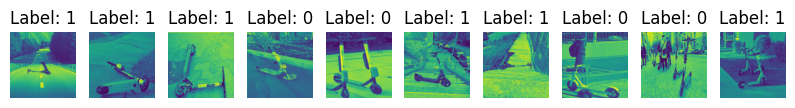

In [ ]:
display_examples( images = scooter_parking_images[102:],
                  labels = scooter_parking_labels[102:] ,
                  num_examples = 10)

##### RGB

In [6]:

scooter_parking_array_path = (r"C:\Users\User\Desktop\Improper escooter parking detection\data\arrays\scooter_parking_rgb.npz")

scooter_parking_images = np.load(scooter_parking_array_path)['images']

scooter_parking_labels = np.load(scooter_parking_array_path)['labels']

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\User\\Desktop\\Improper escooter parking detection\\data\\arrays\\scooter_parking_rgb.npz'

In [7]:
#### COLAB VERSION

from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the file path (Update this if needed)
scooter_parking_path = "/content/drive/MyDrive/Data Science/scooter service /Improper escooter parking detection/data/arrays/scooter_parking_rgb.npz"

# Verify if the file exists
if os.path.exists(scooter_parking_path):
    print("File found! Proceeding with loading...")

    # Load the arrays
    data = np.load(scooter_parking_path)
    scooter_parking_images = data['images']
    scooter_parking_labels = data['labels']

    print("File successfully loaded!")
else:
    print("File not found! Please check the file path in Google Drive.")


Mounted at /content/drive
File found! Proceeding with loading...
File successfully loaded!


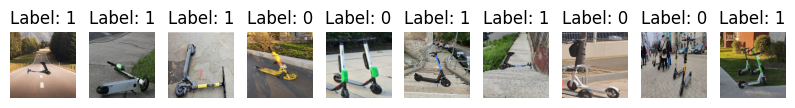

In [8]:
display_examples( images = scooter_parking_images[102:],
                  labels = scooter_parking_labels[102:] ,
                  num_examples = 10)

NOTE : We use RGB here in order to use pretrained models which uses 3 channel images (RGB)

## CLEAN & PREPARE

#### IMAGE TRANSFORMATION

##### GRAYSCALE

In [ ]:
scooter_parking_images,scooter_parking_labels = generate_augmented_images( images = scooter_parking_images,
                                                                           labels = scooter_parking_labels,
                                                                           augmentations_per_image = 10 )


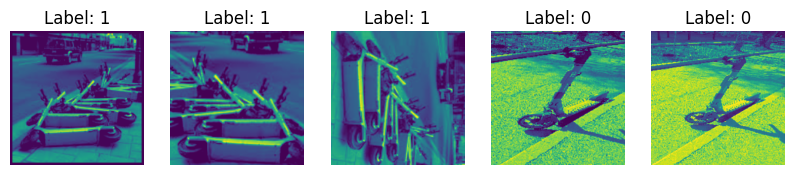

In [ ]:
display_examples( images = scooter_parking_images[127:],
                  labels = scooter_parking_labels[127:] ,
                  num_examples = 5 )

In [ ]:
scooter_parking_images.shape

(2310, 224, 224, 1)

##### RGB

In [9]:
scooter_parking_images,scooter_parking_labels = generate_augmented_images_rgb( images = scooter_parking_images,
                                                                               labels = scooter_parking_labels,
                                                                               augmentations_per_image = 10 )

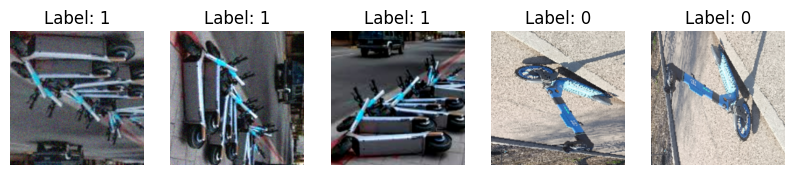

In [10]:
display_examples( images = scooter_parking_images[127:],
                  labels = scooter_parking_labels[127:] ,
                  num_examples = 5 )

In [11]:
scooter_parking_images.shape

(2310, 224, 224, 3)

#### PREPARE DATA FOR MODEL

In [12]:
from sklearn.model_selection import train_test_split

scooter_parking_images_train , scooter_parking_images_test , scooter_parking_labels_train , scooter_parking_labels_test = train_test_split(
    scooter_parking_images,
    scooter_parking_labels ,
    train_size = 0.9 ,
    stratify = scooter_parking_labels ,
    random_state = 42
)


scooter_parking_images_train , scooter_parking_images_validation , scooter_parking_labels_train , scooter_parking_labels_validation = train_test_split(
    scooter_parking_images_train,
    scooter_parking_labels_train ,
    train_size = 0.9 ,
    stratify = scooter_parking_labels_train ,
    random_state = 42
)

In [16]:
print(f'IMAGE ARRAY SHAPES (TRAIN - TEST - VALIDATION) : {scooter_parking_images_train.shape,scooter_parking_images_test.shape,scooter_parking_images_validation.shape}')

IMAGE ARRAY SHAPES (TRAIN - TEST - VALIDATION) : ((1871, 224, 224, 3), (231, 224, 224, 3), (208, 224, 224, 3))


In [15]:
pd.Series(scooter_parking_labels).value_counts()

,count
1,1280
0,1030


## MODEL BUILD

In [17]:
from tensorflow.keras import models , layers , optimizers , losses , callbacks

#### STRUCTURE

In [ ]:
scooter_parking_sequential_neural_net = models.Sequential( [

    layers.Conv2D( filters = 32,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.BatchNormalization(),
    layers.Conv2D( filters = 32,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D( pool_size = (2,2) ),

    layers.Conv2D( filters = 64,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.BatchNormalization(),
    layers.Conv2D( filters = 64,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D( pool_size = (2,2) ),

    layers.Conv2D( filters = 128,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.BatchNormalization(),
    layers.Conv2D( filters = 128,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D( pool_size = (2,2) ),


 ] )

In [ ]:
scooter_parking_sequential_neural_net.add( layers.GlobalAveragePooling2D() )

scooter_parking_sequential_neural_net.add( layers.Dense(units = 128,
                                                        activation = 'relu') )

scooter_parking_sequential_neural_net.add( layers.Dropout(rate = 0.5) )


scooter_parking_sequential_neural_net.add( layers.Dense( units = 1,
                                                         activation = 'sigmoid') )

In [ ]:
scooter_parking_sequential_neural_net.build( input_shape = scooter_parking_images_train.shape )

In [ ]:
scooter_parking_sequential_neural_net.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (1871, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (1871, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (1871, 220, 220, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (1871, 220, 220, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (1871, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (1871, 108, 108, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (1871, 108, 108, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (1871, 106, 106, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (1871, 106, 106, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (1871, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (1871, 51, 51, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (1871, 51, 51, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (1871, 49, 49, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (1871, 49, 49, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (1871, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (1871, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1871, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1871, 128)                 │              

 Total params: 304,865 (1.16 MB)

 Trainable params: 303,969 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

#### COMPILE

In [ ]:
scooter_parking_sequential_neural_net.compile( optimizer = optimizers.Adam(),
                                               loss = losses.BinaryCrossentropy(),
                                               metrics = ['accuracy'] ),

scooter_parking_sequential_neural_net_early_stop = callbacks.EarlyStopping( monitor = 'val_loss',
                                                                            patience = 75,
                                                                            restore_best_weights = True)

#### TRAIN

In [ ]:
train_history = scooter_parking_sequential_neural_net.fit( scooter_parking_images_train,
                                                           scooter_parking_labels_train,
                                                           validation_data = [scooter_parking_images_validation,
                                                                              scooter_parking_labels_validation],
                                                           epochs = 250,
                                                           callbacks = [scooter_parking_sequential_neural_net_early_stop],
                                                           batch_size = 32,
                                                           verbose = 1 )

Epoch 1/250
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 336ms/step - accuracy: 0.5450 - loss: 0.7429 - val_accuracy: 0.4471 - val_loss: 0.8276
Epoch 2/250
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - accuracy: 0.5706 - loss: 0.6795 - val_accuracy: 0.4471 - val_loss: 0.7391
Epoch 3/250
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.6421 - loss: 0.6347 - val_accuracy: 0.4471 - val_loss: 1.0636
Epoch 4/250
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.6418 - loss: 0.6254 - val_accuracy: 0.4471 - val_loss: 0.7248
Epoch 5/250
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.6676 - loss: 0.6092 - val_accuracy: 0.5817 - val_loss: 0.7163
Epoch 6/250
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.6702 - loss: 0.5981 - val_accuracy: 0.5962 - val_loss: 0.6701
Epoch 7/250
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.7275 - loss: 0.5583 - val_accuracy: 0.4519 - val_loss: 0.7660
Epoch 8/250
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.7030 - loss: 0.5531 - val_

#### EVALUATE

In [ ]:
scooter_parking_sequential_neural_net_predictions = scooter_parking_sequential_neural_net.predict( scooter_parking_images_test )

scooter_parking_sequential_neural_net_predictions = (scooter_parking_sequential_neural_net_predictions >= 0.5).astype(int)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step


In [ ]:
from sklearn import metrics

scooter_parking_sequential_neural_net_predictions_report = metrics.classification_report( scooter_parking_labels_test ,
                                                                                          scooter_parking_sequential_neural_net_predictions )

print(scooter_parking_sequential_neural_net_predictions_report)


              precision    recall  f1-score   support

           0       0.90      0.88      0.89       103
           1       0.91      0.92      0.91       128

    accuracy                           0.90       231
   macro avg       0.90      0.90      0.90       231
weighted avg       0.90      0.90      0.90       231



In [ ]:
scooter_parking_sequential_neural_net.evaluate( scooter_parking_images_test,
                                                scooter_parking_labels_test )

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9181 - loss: 0.3053


[0.3966186046600342, 0.9047619104385376]

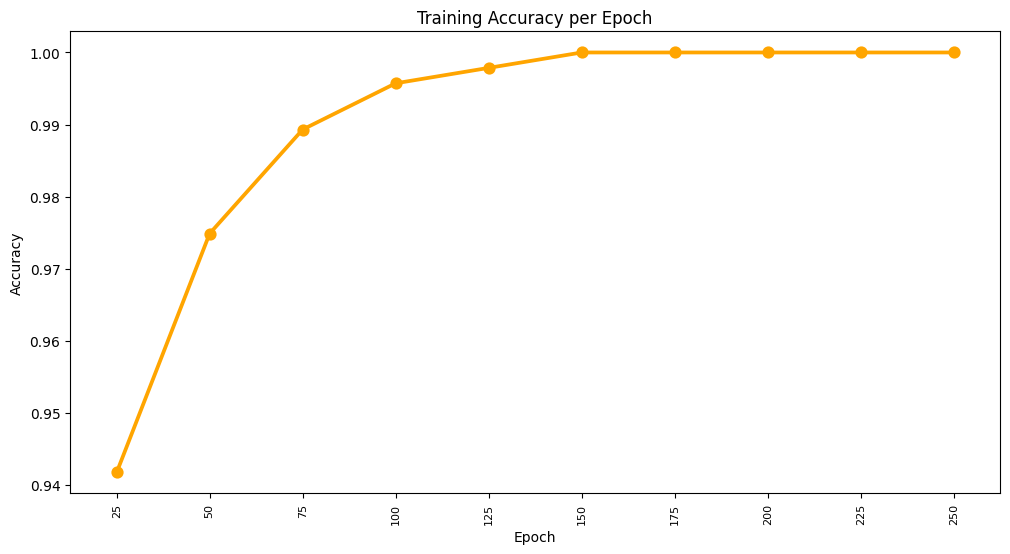

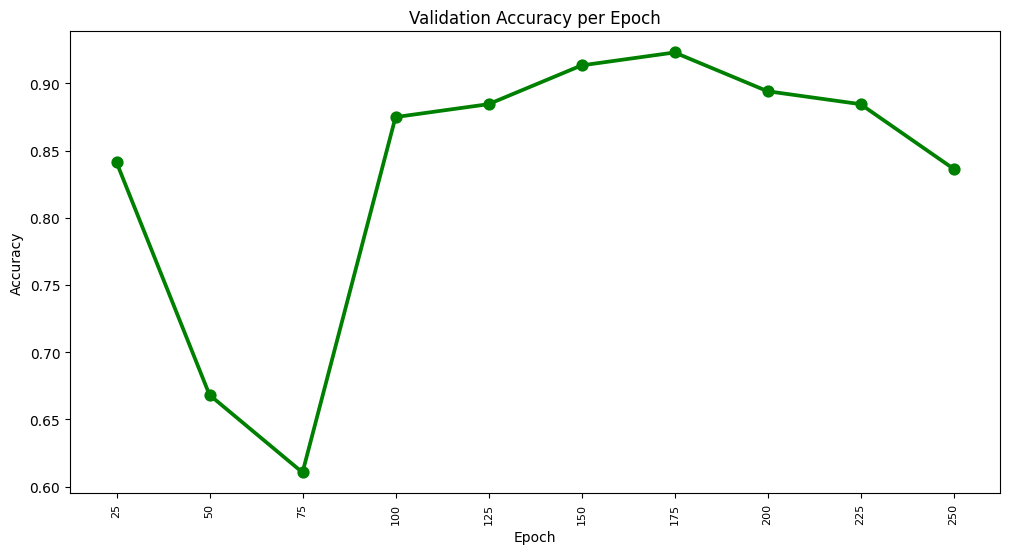

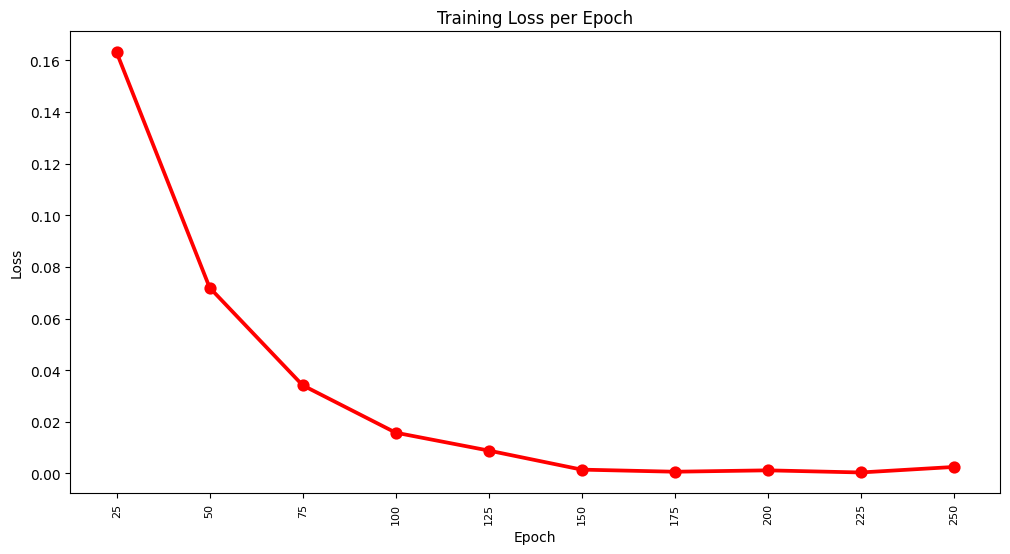

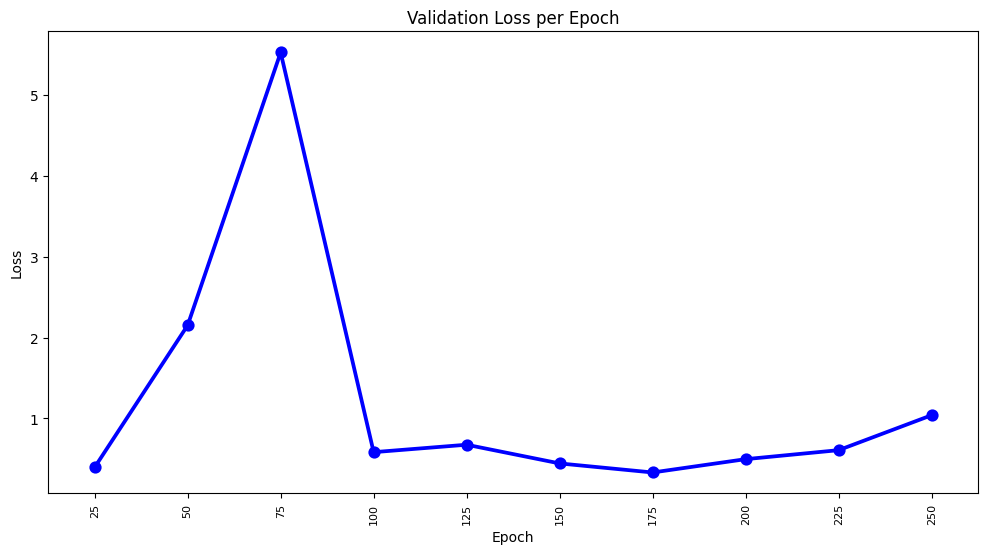

In [ ]:
# Extract history data
history = train_history.history  # Dictionary
epochs = range(1, len(history['accuracy']) + 1)  # Generate epoch numbers

# Convert to DataFrame for easier plotting
history_df = pd.DataFrame({
    'epoch': epochs,
    'accuracy': history['accuracy'],
    'val_accuracy': history['val_accuracy'],
    'loss': history['loss'],
    'val_loss': history['val_loss']
})

# Filter data to only show every 25th epoch
history_filtered = history_df[history_df['epoch'] % 25 == 0]

# Plot Accuracy (Train)
plt.figure(figsize=(12, 6))
plt.xticks(rotation=90, fontsize=8)
sns.pointplot(data=history_filtered, x='epoch', y='accuracy', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Epoch")
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(12, 6))
plt.xticks(rotation=90, fontsize=8)
sns.pointplot(data=history_filtered, x='epoch', y='val_accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.show()

# Plot Loss (Train)
plt.figure(figsize=(12, 6))
plt.xticks(rotation=90, fontsize=8)
sns.pointplot(data=history_filtered, x='epoch', y='loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.show()

# Plot Validation Loss
plt.figure(figsize=(12, 6))
plt.xticks(rotation=90, fontsize=8)
sns.pointplot(data=history_filtered, x='epoch', y='val_loss', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss per Epoch")
plt.show()


### TRANSFER LEARNING

#### STRUCTURE

In [18]:
from tensorflow.keras import applications

In [19]:
scooter_parking_images.shape

(2310, 224, 224, 3)

In [20]:
scooter_parking_mobilenet = applications.MobileNetV2( input_shape = (224, 224, 3),
                                                      include_top = False,
                                                      weights = 'imagenet' )

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [21]:
scooter_parking_mobilenet.trainble = False

In [22]:
scooter_parking_mobilenet.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [23]:
scooter_parking_mobilenet = models.Sequential([

    scooter_parking_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense( units = 128,
                  activation = 'relu'),

    layers.Dropout( rate =  0.5 ),
    layers.Dense( units = 1,
                  activation = 'sigmoid')
])

#### COMPILE

In [24]:
scooter_parking_mobilenet.compile( optimizer = optimizers.Adam(),
                                   loss = losses.BinaryCrossentropy(),
                                   metrics = ['accuracy'] ),

scooter_parking_mobilenet_early_stop = callbacks.EarlyStopping( monitor = 'val_loss',
                                                                patience = 75,
                                                                restore_best_weights = True)

#### TRAIN

In [25]:
scooter_parking_mobilenet_train_history = scooter_parking_mobilenet.fit( scooter_parking_images_train,
                                                                         scooter_parking_labels_train,
                                                                         validation_data = [scooter_parking_images_validation,
                                                                                            scooter_parking_labels_validation],
                                                                         epochs = 120,
                                                                         callbacks = [scooter_parking_mobilenet_early_stop],
                                                                         batch_size = 32,
                                                                         verbose = 1 )

Epoch 1/120
59/59 ━━━━━━━━━━━━━━━━━━━━ 93s 624ms/step - accuracy: 0.7880 - loss: 0.4465 - val_accuracy: 0.5913 - val_loss: 8.4735
Epoch 2/120
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.9404 - loss: 0.1696 - val_accuracy: 0.6010 - val_loss: 9.2771
Epoch 3/120
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9510 - loss: 0.1461 - val_accuracy: 0.5673 - val_loss: 12.7949
Epoch 4/120
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.9686 - loss: 0.0946 - val_accuracy: 0.5529 - val_loss: 15.0328
Epoch 5/120
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.9704 - loss: 0.0758 - val_accuracy: 0.7500 - val_loss: 4.2309
Epoch 6/120
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.9964 - loss: 0.0150 - val_accuracy: 0.5913 - val_loss: 14.1923
Epoch 7/120
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.9859 - loss: 0.0426 - val_accuracy: 0.7981 - val_loss: 3.4555
Epoch 8/120
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.9732 - loss: 0.0786 - v

#### EVALUATE

In [26]:
scooter_parking_mobilenet_predictions = scooter_parking_mobilenet.predict( scooter_parking_images_test )

scooter_parking_mobilenet_predictions = (scooter_parking_mobilenet_predictions >= 0.5).astype(int)


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 615ms/step


In [27]:
from sklearn import metrics

scooter_parking_mobilenet_predictions_report = metrics.classification_report( scooter_parking_labels_test ,
                                                                              scooter_parking_mobilenet_predictions )

print(scooter_parking_mobilenet_predictions_report)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       103
           1       1.00      0.95      0.97       128

    accuracy                           0.97       231
   macro avg       0.97      0.97      0.97       231
weighted avg       0.97      0.97      0.97       231



In [29]:
scooter_parking_mobilenet.evaluate( scooter_parking_images_test,
                                    scooter_parking_labels_test )

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 651ms/step - accuracy: 0.9638 - loss: 0.3759


[0.31393590569496155, 0.9696969985961914]

### SAVE

##### ORIGINAL CNN

In [ ]:
scooter_parking_sequential_neural_net.save('scooter_parking_sequential_neural_net.keras')

##### MobileNetV2

In [30]:
scooter_parking_mobilenet.save('scooter_parking_mobilenet.keras')